# Delithiation and obtain the voltages

Delithiate the search results and found find there voltages properly

In [1]:
%aiida
import pandas as pd
from aiida.orm import KpointsData, StructureData

from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

## Read the data

In [2]:
df = pd.read_csv("delithiation-selected.csv")
df.sort_values('e_pa', inplace=True)

In [3]:
df['relaxed_structure'] = df.relax_structure_uuid.apply(lambda x: load_node(x))

## Delithiation results

In [4]:
group = Group.objects.get(label='li-fe-o-f/delithiation-starting-relaxes')

In [15]:
q = QueryBuilder()
q.append(Group, filters={'id': group.pk})
q.append(Node, with_group=Group, project=['label', 'uuid'])
q.append(StructureData, project=['label', 'uuid', '*'])
q.append(WorkChainNode, tag='deli', project='uuid', filters={'process_type': {'like': '%deli%'}})
q.append(Dict, project=['attributes'], edge_filters={'label': {'like': '%voltages'}})
q.append(Dict, project=['attributes'], with_incoming='deli', edge_filters={'label': 'output_parameters'})

q.all()

voltage_data = pd.DataFrame(q.all(), columns=['relax_label', 'relax_uuid', 'struct_label', 'struct_uuid', 'struct', 'deli_uuid', 'voltage_dict', 'deli_data'])
voltage_data['voltages'] = voltage_data.voltage_dict.apply(lambda x: x['voltage'])

voltage_data['min_voltages'] = voltage_data['voltages'].apply(lambda x: min(x))
voltage_data['avg_voltages'] = voltage_data['voltages'].apply(lambda x: np.mean(x))

voltage_data = voltage_data.merge(df, on='relax_uuid', how='left')
voltage_data = voltage_data.loc[voltage_data.groupby('formula').e_above_hull.idxmin()]

mean_voltages = voltage_data.groupby('formula').avg_voltages.mean()
min_voltages = voltage_data.groupby('formula').min_voltages.min()
above_hull = voltage_data.groupby('formula').e_above_hull.min()

In [16]:
voltage_data.deli_uuid.to_list()

['6e026ea5-0687-4559-b0dc-e18c1373a67d',
 '834fe9a4-5a7b-4f0f-9ce9-82416a2f1be7',
 '952b260a-37d9-41f5-8c42-4c628682eef1',
 '1d727e34-9367-4628-b0f8-1688ff430369',
 '86b7066b-ef64-4abe-8b76-cc776506893d',
 '1faf7138-e2e9-4c41-96a4-a3d5b2436661',
 '3b8edea7-b3e4-4500-82e5-7664220a2c44',
 'e5aa54b1-31cf-4283-985a-6e8361dfe5dd',
 'fc3028cd-8a72-439e-9d0f-1db52df50de6',
 'de82dcb5-6836-4942-8002-ed003f6dacba',
 'fdb87eb0-8383-431d-902d-70e777aa01ef']

<AxesSubplot:xlabel='formula'>

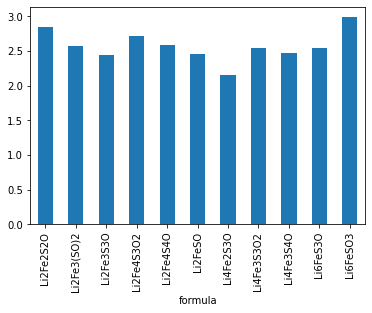

In [17]:
mean_voltages.plot.bar()

<AxesSubplot:xlabel='formula'>

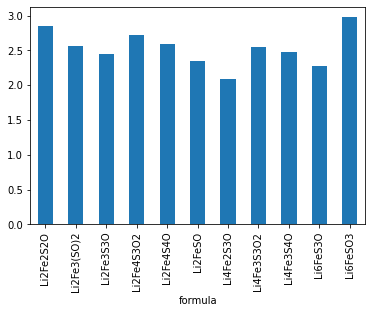

In [18]:
min_voltages.plot.bar()

In [19]:
voltage_formula = pd.concat([min_voltages, mean_voltages, above_hull], axis=1)

(1.5, 3.0)

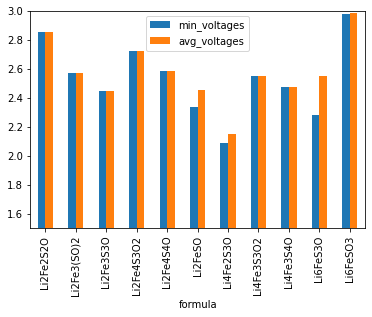

In [20]:
ax = voltage_formula.plot.bar(y=['min_voltages', 'avg_voltages'])
ax.set_ylim(1.5, 3.0)

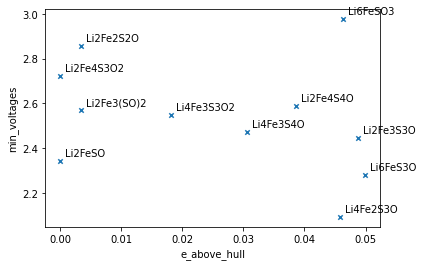

In [21]:
ax = voltage_formula.plot.scatter(x='e_above_hull', y='min_voltages', marker='x')

for form, row in voltage_formula.iterrows():
    ax.annotate(form, (row.e_above_hull, row.min_voltages), (5, 5), textcoords='offset points')

## Assemble a table

Shows the best structure of each compositions and its energy above hull value, the voltage (min) and the volume change,
expected current density and the energy density

In [24]:
from toolchest.metrics import TheoreticalCathode
from pymatgen import Composition

def compute_capacity(row):
    """Compute the capacity"""
    comp = Composition(row.formula)
    nli = min(comp['Fe'], comp['Li'])
    cathode = TheoreticalCathode(comp, nli=nli, avg_voltage=row.min_voltages, label=row.formula)
    return cathode.mAhg, cathode.Whkg

In [25]:
most_stable = voltage_data.loc[voltage_data.groupby('formula')['e_above_hull'].idxmin()]

In [26]:
records = []
indices = []
for idx, row in most_stable.iterrows():
    deli_data = row.deli_data
    voltage_data = row.voltage_dict
    imin = np.argsort(voltage_data['voltage'])[0]
    ideli = len(voltage_data['voltage'])
    vols = []
    for i in range(ideli):
        inp = load_node(deli_data['input_structure'][i])
        out = load_node(deli_data['output_structure'][i])
        vols.append((out.get_cell_volume() - inp.get_cell_volume()) / inp.get_cell_volume())
    mahg, whkg = compute_capacity(row)
    records.append([vols[imin], voltage_data, mahg, whkg])
    indices.append(idx)
extra_prop = pd.DataFrame(records, columns=['volume_change', 'voltage_data', 'mAh/g', 'Wh/kg'], index=indices)

output = pd.concat([most_stable, extra_prop], axis=1)

output[['formula', 'min_voltages', 'volume_change', 'e_above_hull', 'mAh/g', 'Wh/kg', 'decomp']].sort_values('e_above_hull')

,formula,min_voltages,volume_change,e_above_hull,mAh/g,Wh/kg,decomp
8,Li2FeSO,2.339992,-0.039256,0.000000e+00,227.533431,532.426506,Li2FeSO
0,Li2Fe4S3O2,2.720278,-0.078109,8.881784e-16,146.674270,398.994750,Li2Fe4S3O2
1,Li2Fe3(SO)2,2.568085,-0.099105,3.356444e-03,193.131954,495.979243,Li2FeSO+FeO+Li2Fe4S3O2
3,Li2Fe2S2O,2.854146,-0.117095,3.385171e-03,260.586281,743.751234,Li2Fe4S3O2+Li2S
9,Li4Fe3S3O2,2.549100,-0.033542,1.807660e-02,248.550954,633.581231,Li2FeSO+Li2Fe4S3O2+Li2S
7,Li4Fe3S4O,2.472016,-0.037815,3.053905e-02,236.791209,585.351645,Li2Fe4S3O2+FeS+Li2S
2,Li2Fe4S4O,2.586309,-0.069035,3.862633e-02,140.497919,363.370995,Li2Fe4S3O2+FeS+Li2S
10,Li4Fe2S3O,2.091393,-0.055008,4.579586e-02,213.007366,445.482127,Li2Fe4S3O2+Li2S
4,Li6FeSO3,2.975395,-0.006964,4.629966e-02,150.948169,449.130468,Li2O+Li2FeO2+Li2S
5,Li2Fe3S3O,2.445469,-0.075694,4.883292e-02,182.564310,446.455392,Li2Fe4S3O2+FeS+Li2S
